## Purpose of This Notebook

This notebook prepares the **CBIS-DDSM mammogram dataset** for deep learning applications through a complete preprocessing pipeline. It performs the following key steps:  

- **Load pathology metadata** from CSV and extract standardized patient identifiers.  
- **Recursively scan** the dataset to collect all DICOM image file paths.  
- **Extract and standardize image metadata** (breast laterality, view type) from directory structures.  
- **Merge image paths with pathology labels** using common keys (`Patient_ID`, `image view`).  
- **Standardize diagnostic categories**, e.g., merge `BENIGN_WITHOUT_CALLBACK` into `BENIGN`.  
- **Preprocess DICOM images**: normalization, CLAHE contrast enhancement, resizing to 224×224, and conversion to RGB format.  
- **Visualize original vs. preprocessed images** for quality control.  
- **Apply data augmentation** (flips, rotations, zooms, etc.) to increase dataset variability and improve model generalization.  
- **Save preprocessed and augmented images** with their corresponding labels for downstream training.  

This pipeline ensures the dataset is:  

- **Clean and consistently labeled** for reproducible experiments.  
- **Preprocessed and standardized** to match model input requirements.  
- **Augmented** to reduce overfitting and improve robustness on limited medical imaging data.  

> A separate notebook will use these prepared datasets to train and evaluate various CNN architectures — including VGG16, ResNet50, DenseNet121, and InceptionNet — for breast lesion classification, with Grad-CAM visualizations to interpret model predictions.lassification and Grad-CAM visualization.


## Step 1: Load and Standardize Mammography Metadata

This script reads metadata from the `mass_case_description_train_set.csv` file, standardizes pathology labels, and formats patient IDs for consistency. Specifically:
- It merges the `BENIGN_WITHOUT_CALLBACK` class into the `BENIGN` category to simplify classification.
- It extracts the numeric part of each patient ID, ensuring all IDs are zero-padded to 5 digits.
- A preview of the processed DataFrame is printed for verification.

This step ensures clean and consistent metadata before image preprocessing and model training.

In [1]:
import pandas as pd
import os
import pydicom

# Step 1: Load metadata CSV
csv_path = r"C:\Users\Admin\School\FYP\mass_case_description_train_set.csv"
df = pd.read_csv(csv_path)

# Standardize pathology column (merge BENIGN_WITHOUT_CALLBACK into BENIGN)
df['pathology'] = df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')

# Extract numeric patient ID and zero-fill
df['Patient_ID'] = df['patient_id'].str.replace('P_', '').str.zfill(5)

# Display preview
print("Step 1: Metadata Sample")
print(df[['patient_id', 'Patient_ID', 'pathology']].head())

C:\Users\Admin\anaconda3\envs\tf_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Step 1: Metadata Sample
  patient_id Patient_ID  pathology
0    P_00001      00001  MALIGNANT
1    P_00001      00001  MALIGNANT
2    P_00004      00004     BENIGN
3    P_00004      00004     BENIGN
4    P_00004      00004     BENIGN


## Step 2: Extract DICOM File Paths and Parse Metadata

This step recursively collects all `.dcm` (DICOM) image files from the CBIS-DDSM dataset directory and builds a structured DataFrame containing relevant metadata. Specifically:  

- Recursively scans the dataset folder to gather the full file paths of all DICOM images.  
- Extracts key metadata — **Patient ID**, **breast laterality** (LEFT or RIGHT), and **image view** (e.g., CC or MLO) — from the folder names, following the CBIS-DDSM naming convention.  
- Constructs a DataFrame mapping each DICOM file to its corresponding metadata, enabling easier integration with diagnosis labels and further preprocessing steps.  

This ensures that all image file paths are paired with meaningful metadata before merging with clinical labels and proceeding to image analysis.


In [2]:
import glob

# Step 2: Extract all DICOM file paths
dicom_root = r"C:\Users\Admin\School\FYP\CBIS-DDSM"
dicom_paths = glob.glob(os.path.join(dicom_root, "**", "*.dcm"), recursive=True)

# Build a DataFrame of DICOM paths
dicom_df = pd.DataFrame({'Full_File_Path': dicom_paths})

# Fixed extract_info function to get both laterality and view
def extract_info(path):
    parts = path.split(os.sep)
    for part in parts:
        if part.startswith("Mass-Training_P_"):
            segments = part.split("_")
            patient_id = segments[2]           # e.g., '00314'
            laterality = segments[3]           # LEFT or RIGHT
            view = segments[4] if len(segments) > 4 else None  # CC or MLO
            return patient_id, laterality, view
    return None, None, None

# Apply updated function
dicom_df[['Patient_ID', 'left or right breast', 'image view']] = dicom_df['Full_File_Path'].apply(
    lambda x: pd.Series(extract_info(x))
)

# Display preview
print("\nStep 2: DICOM Paths Sample")
print(dicom_df.head())


Step 2: DICOM Paths Sample
                                      Full_File_Path Patient_ID  \
0  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...      00419   
1  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...      00419   
2  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...      00420   
3  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...      00420   
4  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...      00421   

  left or right breast image view  
0                RIGHT         CC  
1                RIGHT        MLO  
2                RIGHT         CC  
3                RIGHT        MLO  
4                 LEFT         CC  


## Step 3: Merge Metadata with DICOM File Paths

This step combines the standardized metadata from the CSV file (including diagnostic labels such as `pathology`) with the extracted DICOM file paths, using `Patient_ID` and `image view` as the matching keys.  

Key actions:  
- Perform an **inner merge** to ensure only records with both valid labels and matching DICOM files are retained.  
- Produce a unified DataFrame linking each mammogram image to its corresponding diagnostic label and metadata.  
- Save the merged dataset as a CSV file for reproducibility and downstream processing.  

This merged dataset serves as the foundation for the image–label pipeline, enabling consistent input for deep learning model training and evaluation.

In [3]:
# Step 3: Merge on Patient_ID and image view
merged_df = pd.merge(df, dicom_df, on=['Patient_ID', 'image view'], how='inner')

print("\nStep 3: Merged Dataset Sample")
print(merged_df[['Patient_ID', 'image view', 'pathology', 'Full_File_Path']].head())
print(f"Merged {len(merged_df)} rows")
# Save merged_df to CSV
merged_df.to_csv(r"C:\Users\Admin\School\FYP\merged_df.csv", index=False)


Step 3: Merged Dataset Sample
  Patient_ID image view  pathology  \
0      00419         CC     BENIGN   
1      00419         CC  MALIGNANT   
2      00419        MLO  MALIGNANT   
3      00419        MLO     BENIGN   
4      00419         CC     BENIGN   

                                      Full_File_Path  
0  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...  
1  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...  
2  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...  
3  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...  
4  C:\Users\Admin\School\FYP\CBIS-DDSM\Mass-Train...  
Merged 1099 rows


## Step 4: Preprocess and Save Mammogram Images

In this step, raw DICOM mammogram images are read, enhanced, resized, and saved as preprocessed PNG files suitable for deep learning model input.  

Key actions:  
- **Contrast Enhancement** — Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve local contrast and reveal subtle features.  
- **Normalization** — Scale pixel values to the range 0–255 for consistent intensity distribution.  
- **Resizing** — Resize all images to a fixed resolution of 224×224 pixels for model compatibility.  
- **Channel Conversion** — Convert grayscale images to 3-channel RGB format to match common CNN input requirements.  
- **Label Assignment** — Encode `pathology` as binary labels (`1` for MALIGNANT, `0` for BENIGN).  
- **Saving** — Store processed images in the `preprocessed_pngs` directory with filenames containing their label.  
- **Augmentation Preview (Optional)** — Apply random transformations (flips, rotations, zoom) to preview possible data augmentation effects, shown only for the first few samples and not saved.  

This preprocessing step standardizes all input images, ensuring they are clean, uniform, and ready for model training.
verify their quality.

  0%|          | 0/1099 [00:00<?, ?it/s]

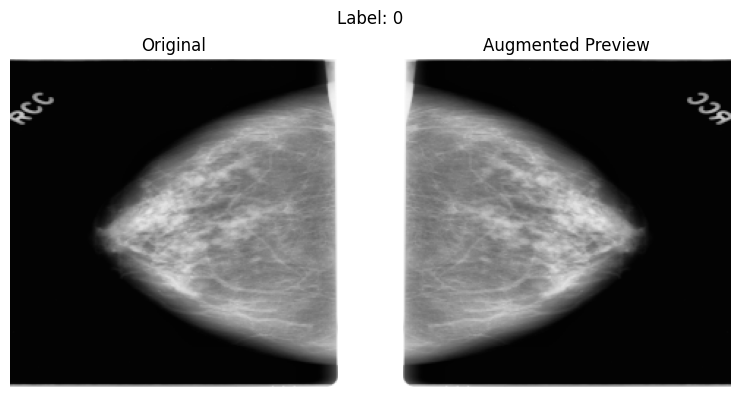

  0%|          | 1/1099 [00:00<04:46,  3.83it/s]

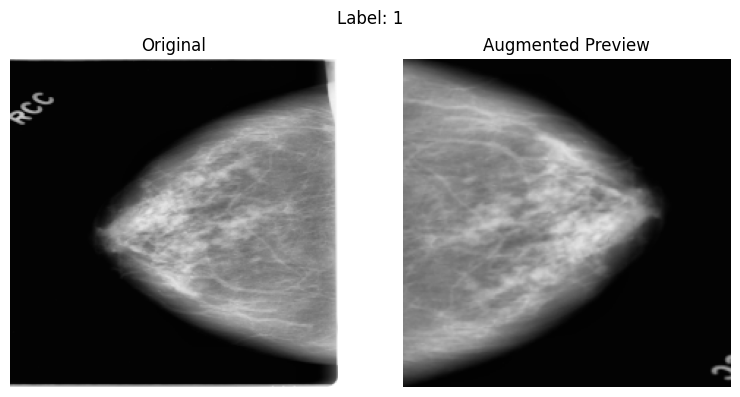

  0%|          | 2/1099 [00:00<04:13,  4.33it/s]

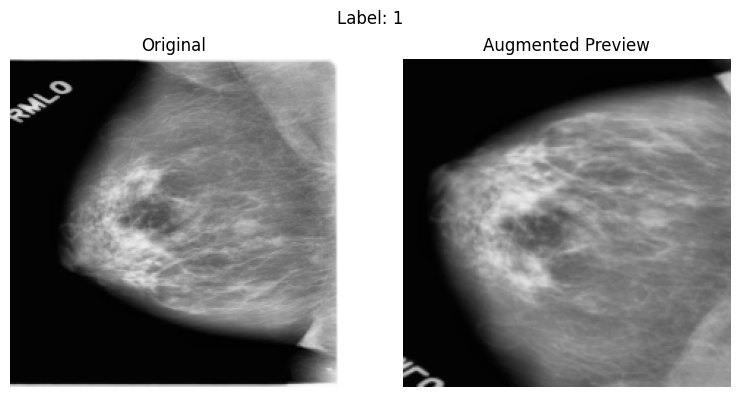

100%|██████████| 1099/1099 [02:38<00:00,  6.95it/s]


Saved 1400 preprocessed PNGs to 'preprocessed_pngs'


In [6]:
import os
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Output folder for preprocessed PNGs
output_png_dir = "preprocessed_pngs"
os.makedirs(output_png_dir, exist_ok=True)

# CLAHE object for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Function: Preprocess DICOM image
def preprocess_image(dicom_path, target_size=(224, 224)):
    dcm = pydicom.dcmread(dicom_path)
    img = dcm.pixel_array.astype(np.float32)

    # Normalize to 0–255
    img -= np.min(img)
    if np.max(img) != 0:
        img /= np.max(img)
    img *= 255.0
    img = img.astype(np.uint8)

    # Apply CLAHE
    img = clahe.apply(img)

    # Resize
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    # Convert grayscale to 3-channel RGB
    img_rgb = np.stack([img] * 3, axis=-1)
    return img_rgb

# Data augmentation for preview only
def augment_image(img):
    if random.random() < 0.5:
        img = cv2.flip(img, 1)  # horizontal flip
    if random.random() < 0.5:
        img = cv2.flip(img, 0)  # vertical flip
    if random.random() < 0.5:
        angle = random.choice([90, 180, 270])
        img_center = tuple(np.array(img.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(img_center, angle, 1.0)
        img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    if random.random() < 0.5:
        zoom_factor = random.uniform(1.1, 1.3)
        h, w = img.shape[:2]
        zoomed = cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)
        startx = (zoomed.shape[1] - w) // 2
        starty = (zoomed.shape[0] - h) // 2
        img = zoomed[starty:starty+h, startx:startx+w]
    return img

# Process all DICOM images
for idx, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0]):
    dicom_path = row['Full_File_Path']
    if not os.path.isfile(dicom_path):
        print(f"Warning: File not found {dicom_path}")
        continue

    label = 1 if row['pathology'] == 'MALIGNANT' else 0
    img = preprocess_image(dicom_path)

    # Save original preprocessed image only
    save_path = os.path.join(output_png_dir, f"{idx:05d}_label{label}.png")
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    # Show augmentation preview for first 3 samples (not saved)
    if idx < 3:
        aug_img = augment_image(img.copy())
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img)
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(aug_img)
        axs[1].set_title("Augmented Preview")
        axs[1].axis('off')

        plt.suptitle(f"Label: {label}")
        plt.tight_layout()
        plt.show()

print(f"\nSaved {len(os.listdir(output_png_dir))} preprocessed PNGs to '{output_png_dir}'")

